In [1]:
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
# paper: https://arxiv.org/abs/0802.4411
# based on Zhang, L. implementation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')

def Heston_Calls(series):
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho = series['rho'] # Correlation
    v0 = series['Cv0'] # Initial Variance (I use Call Implied Volatility from BSM instead)
    T = series['T'] # Time to maturity
    s0 = series['s0'] # Spot Price
    K = series['K'] # Strike Price
    N = 10000 # Nº of simulations
    dt = 1/32 # Timestep granularity (related to the nº of steps being generated)
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    v=np.ones(N)*v0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v=v2
    payoff=np.maximum(S-K,0)
    return np.mean(payoff)

def Heston_Puts(series):
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho = series['rho'] # Correlation
    v0 = series['Pv0'] # Initial Variance (I use Put Implied Volatility from BSM instead)
    T = series['T'] # Time to maturity
    s0 = series['s0'] # Spot Price
    K = series['K'] # Strike Price
    N = 10000 # Nº of simulations
    dt = 1/32 # Timestep granularity (related to the nº of steps being generated)
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    v=np.ones(N)*v0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v=v2
    payoff=np.maximum(K-S,0)
    return np.mean(payoff)

db = pd.read_hdf("optiondata.h5")
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
HTest = pd.DataFrame({'T': db['Expiration'],'Cv0': db['CallImpVol']**2, 'Now': db['Now'],
                     's0': db['Spot'],'Pv0': db['PutImpVol']**2,'Put': db['PutMid'],
                     'K': db['Strike'],'Call': db['CallMid'],'Maturity': db['Maturity']})

HTest[HTest['Cv0'] < 0.001] = 0
HTest[HTest['Pv0'] < 0.001] = 0
HTest = HTest.loc[(HTest!=0).any(1)]
HTest = HTest.reset_index().drop('index',axis=1)

# requires recalibration!
HTest['Moneyness'] = abs(HTest['K']/HTest['s0'])
HTest['theta'] = 0.49254
HTest['kappa'] = 0.05749
HTest['sigma'] = 0.29549
HTest['rho'] = 0.08996

In [3]:
HTest['Heston Call'] = round(HTest.apply(Heston_Calls, axis=1),2)
HTest['CError'] = HTest['Heston Call']/HTest['Call']-1
abs(HTest['CError']).describe()

count    429.000000
mean       0.662874
std        0.822465
min        0.007087
25%        0.181417
50%        0.332029
75%        0.789588
max        4.593939
Name: CError, dtype: float64

In [4]:
HTest['Heston Put'] = round(HTest.apply(Heston_Puts, axis=1),2)
HTest['PError'] = HTest['Heston Put']/HTest['Put']-1
abs(HTest['PError']).describe()

count    429.000000
mean       0.059459
std        0.050576
min        0.000148
25%        0.014109
50%        0.046070
75%        0.095004
max        0.213138
Name: PError, dtype: float64

In [5]:
HTest.groupby('Maturity')['CError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,-0.105815,0.066338,-0.235294,-0.151667,-0.118447,-0.060255,0.052941
2018-06-15 17:30:00,62.0,1.002503,0.881418,0.168637,0.276319,0.655230,1.441864,3.252632
2018-09-21 17:30:00,105.0,0.857790,1.101352,0.078263,0.162071,0.361603,0.984221,4.593939
2018-12-21 17:30:00,125.0,0.742773,0.799322,0.108975,0.233249,0.429977,0.907798,3.467568
2019-03-15 17:30:00,98.0,0.357628,0.192265,0.131220,0.202504,0.295108,0.480841,0.908506


In [6]:
HTest.groupby('Maturity')['PError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,-0.108362,0.045473,-0.198868,-0.142949,-0.102206,-0.067148,-0.043920
2018-06-15 17:30:00,62.0,-0.003683,0.012301,-0.032180,-0.012373,-0.003098,0.003885,0.020438
2018-09-21 17:30:00,105.0,0.014338,0.015754,-0.030311,0.004721,0.010793,0.023492,0.060518
2018-12-21 17:30:00,125.0,0.055475,0.023942,0.012107,0.036590,0.051284,0.072800,0.112174
2019-03-15 17:30:00,98.0,0.122419,0.030972,0.064089,0.097704,0.119307,0.146296,0.213138


<IPython.core.display.Javascript object>


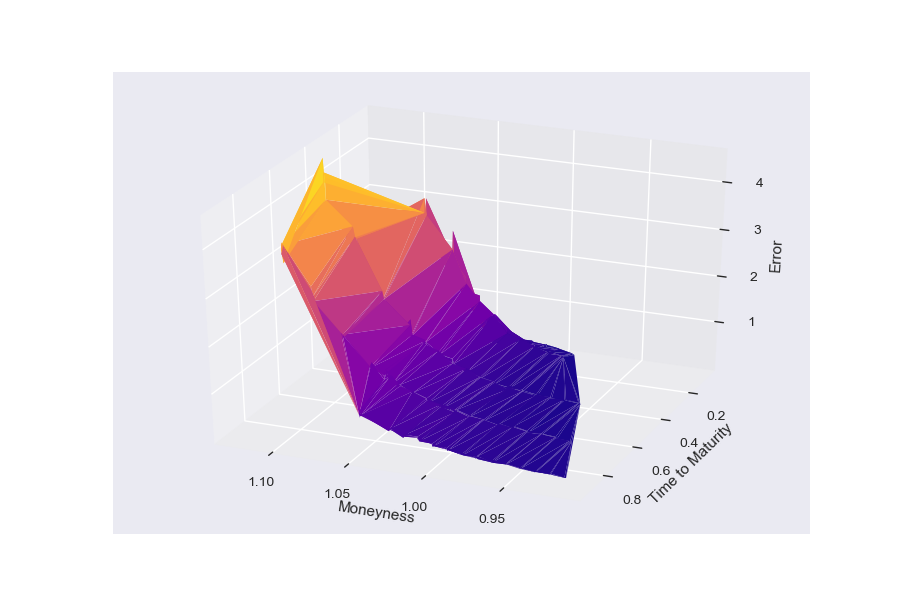

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['CError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()

<IPython.core.display.Javascript object>


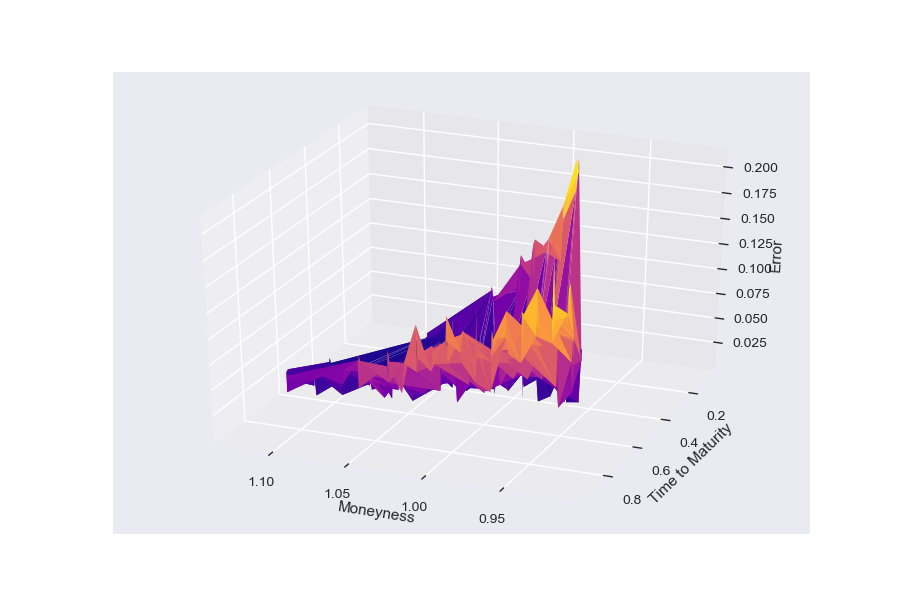

In [8]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['PError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()